# Clustering project

Descrição

## Importing data and libraries

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import AgglomerativeClustering

In [28]:
cust_basket = pd.read_csv('data/customer_basket.csv')
cust_info = pd.read_csv('data/customer_info.csv', index_col=0)
product_mapping = pd.read_excel('data/product_mapping.xlsx')

## Exploratory Data Analysis

### Data cleaning and preprocessing

In [ ]:
# Initial visualizations
display(cust_info.head())
display(cust_info.info())
display(cust_info.describe())
display(cust_info.describe(include=object))

display(cust_basket.head())
display(cust_basket.info())
display(cust_basket.describe())
display(cust_basket.describe(include=object))

product_mapping

In [32]:
# Missing values - Using KNNImputer

# Convert birth date to datetime and extract age
cust_info['customer_birthdate'] = pd.to_datetime(cust_info['customer_birthdate'])
cust_info['age'] = cust_info['customer_birthdate'].apply(lambda x: (pd.Timestamp.now() - x).days // 365)

# Drop non-numeric columns for imputation
numeric_cols = cust_info.select_dtypes(include=[np.number]).columns
non_numeric_cols = cust_info.select_dtypes(exclude=[np.number]).columns

# KNN Imputation
imputer = KNNImputer(n_neighbors=5)
cust_info[numeric_cols] = imputer.fit_transform(cust_info[numeric_cols])

# Combine numeric and non-numeric columns back
cust_info = pd.concat([cust_info[non_numeric_cols], cust_info[numeric_cols]], axis=1)


C:\Users\msard\AppData\Local\Temp\ipykernel_9296\2705198453.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cust_info['customer_birthdate'] = pd.to_datetime(cust_info['customer_birthdate'])
c:\Users\msard\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\msard\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


In [ ]:
# Convert purchases from strings to actual lists
cust_basket['list_of_goods'] = cust_basket['list_of_goods'].apply(eval)

# Create a dictionary from product mapping
product_mapping_dict = pd.Series(product_mapping['category'].values, index=product_mapping['product_name']).to_dict()

# Map each item in the list_of_goods to its category
cust_basket['categories'] = cust_basket['list_of_goods'].apply(lambda x: [product_mapping_dict.get(item, 'Unknown') for item in x])

# Create the category columns with counts of items purchased in each category
for category in product_mapping['category'].unique():
    cust_basket[category] = cust_basket['categories'].apply(lambda x: x.count(category))

# Drop the intermediate 'categories' column
cust_basket = cust_basket.drop(columns=['categories'])

# Display the processed cust_basket data
print(cust_basket.head())


### Visualizations

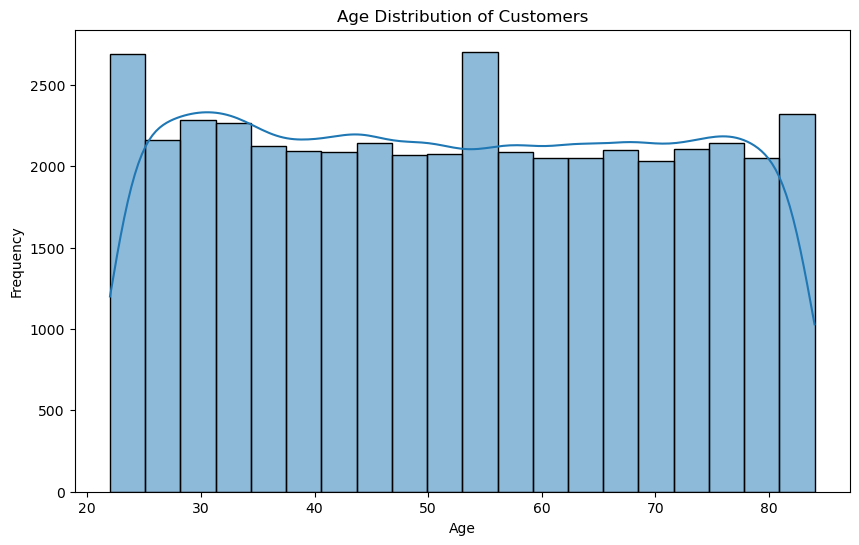

In [34]:
# Age distribution
plt.figure(figsize=(10, 6))
sns.histplot(cust_info['age'], bins=20, kde=True)
plt.title('Age Distribution of Customers')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

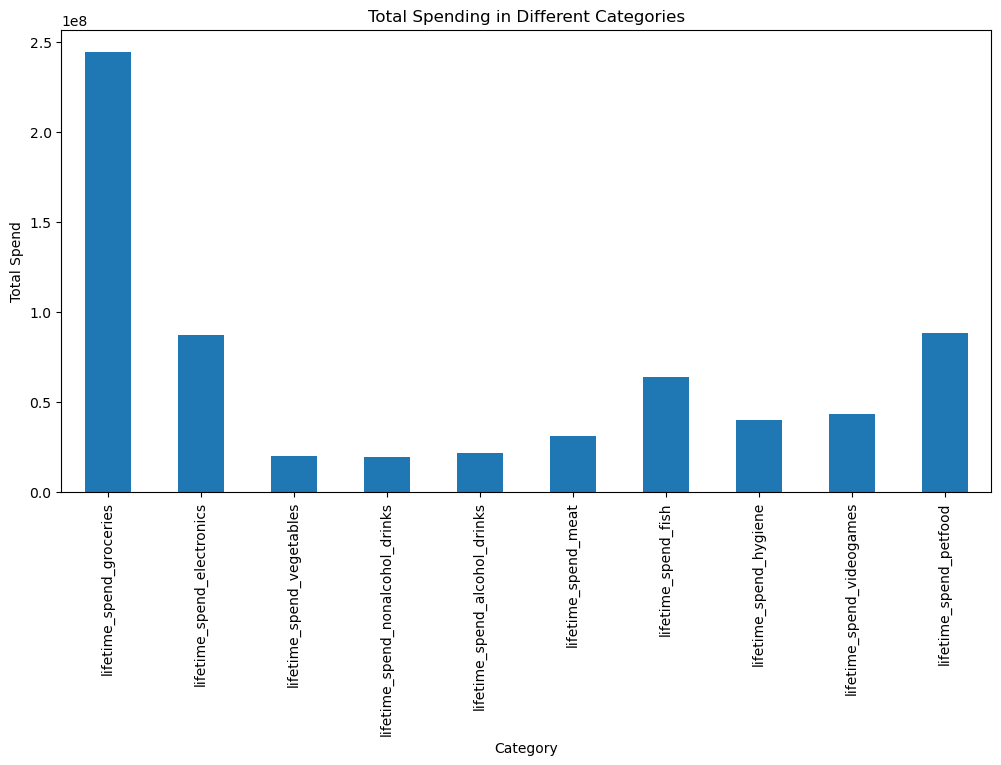

In [35]:
# Taking the columns about spending
spending_columns = [col for col in cust_info.columns if 'lifetime_spend' in col]

# Plotting
cust_info[spending_columns].sum().plot(kind='bar', figsize=(12, 6))
plt.title('Total Spending in Different Categories')
plt.xlabel('Category')
plt.ylabel('Total Spend')
plt.show()

#### Analysis

Patterns Identified:

Outliers and anomalies:

Correlations and relationships:

## Customer Segmentation

### Clustering

In [38]:
# Select relevant columns for clustering
features = cust_info.drop(columns=['customer_id', 'customer_name', 'customer_gender', 'customer_birthdate', 'loyalty_card_number', 'latitude', 'longitude'])

# Standardize the data
scaler = RobustScaler()
scaled_features = scaler.fit_transform(features)

# Apply Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=5)
cust_info['cluster'] = agg_clustering.fit_predict(scaled_features)

c:\Users\msard\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\msard\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


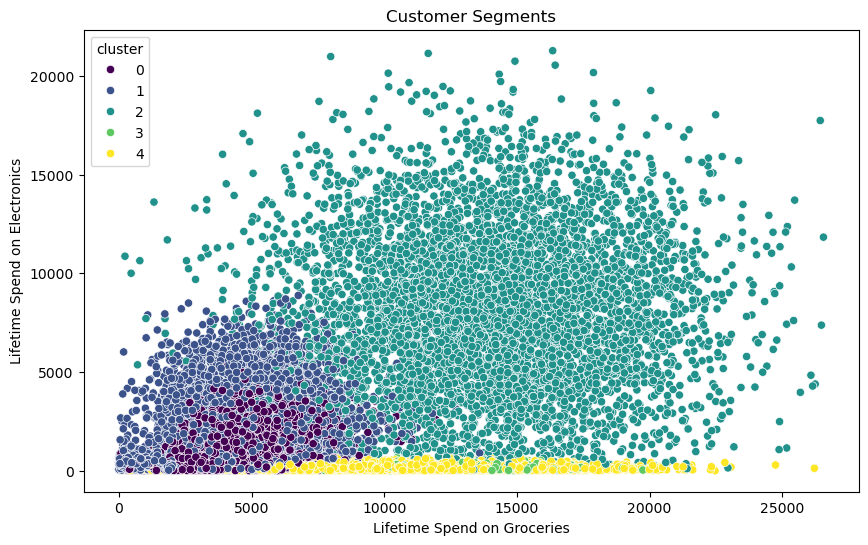

In [39]:
# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='lifetime_spend_groceries', y='lifetime_spend_electronics', hue='cluster', data=cust_info, palette='viridis')
plt.title('Customer Segments')
plt.xlabel('Lifetime Spend on Groceries')
plt.ylabel('Lifetime Spend on Electronics')
plt.show()

### Segment Descriptions

In [45]:
# Separate numerical and categorical columns
numerical_cols = cust_info.select_dtypes(include=['number']).columns
categorical_cols = cust_info.select_dtypes(include=['object']).columns

# Define aggregation functions
aggregation = {col: 'mean' for col in numerical_cols}
aggregation.update({col: lambda x: x.mode().iloc[0] for col in categorical_cols})

# Analyze purchasing patterns per cluster
cluster_summary = cust_info.groupby('cluster').agg(aggregation)

# Print the summary statistics
display(cluster_summary)


,customer_id,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,typical_hour,lifetime_spend_vegetables,lifetime_spend_nonalcohol_drinks,...,lifetime_total_distinct_products,percentage_of_products_bought_promotion,year_first_transaction,loyalty_card_number,latitude,longitude,age,cluster,customer_name,customer_gender
cluster,,,,,,,,,,,,,,,,,,,,,
0,24823.885776,1.981849,1.195116,0.743960,1.170969,3952.705759,1182.078071,15.545167,756.010079,397.469579,...,360.941803,0.198368,2011.116869,949850.289317,38.748680,-9.156263,54.349657,0.0,Anthony Smith,female
1,25155.018048,0.659827,0.737229,0.786797,2.313595,3148.236504,1251.002901,12.353870,268.124295,424.047859,...,579.019391,0.312278,2011.649460,948479.921448,38.747385,-9.155775,49.796261,1.0,James Brown,male
2,25076.643578,1.001630,0.995748,0.500726,1.389300,14012.167050,8112.772011,13.625828,499.543667,596.570593,...,100.733747,0.049657,2011.142250,950113.733392,38.752249,-9.146188,54.642870,2.0,Christopher Thomas,female
3,24948.820779,0.024416,0.034805,0.502338,1.000519,13868.659740,187.896104,10.040000,405.995325,308.402597,...,19.838961,0.397186,2011.231169,947946.047792,39.165533,-9.398706,53.898701,3.0,John`s Fishy,male
4,24763.590898,0.000000,0.011884,0.505730,1.000094,10141.790615,159.942231,11.865268,198.728696,498.830936,...,51.709502,0.197791,2011.053525,955055.811648,38.748669,-9.173753,54.756661,4.0,Carol Williams,female


### Segment Comparison

In [46]:
# For each cluster, develop targeted strategies
for cluster_id in cust_info['cluster'].unique():
    cluster_data = cust_info[cust_info['cluster'] == cluster_id]
    print(f"Cluster {cluster_id} - Marketing Strategies:")
    # Example: If majority spend is on groceries
    if cluster_data['lifetime_spend_groceries'].mean() > cluster_data.drop(columns=['lifetime_spend_groceries']).mean(axis=1).mean():
        print("  - Promote grocery-related discounts and loyalty programs.")
    # Example: If majority are younger customers
    if cluster_data['age'].mean() < 30:
        print("  - Target with digital campaigns and trendy product promotions.")
    print()

Cluster 2 - Marketing Strategies:


TypeError: can only concatenate str (not "Timestamp") to str

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_variable_distributions(dataframe, cluster_column, figsize=(15, 15)):
    """
    Plot distributions of all variables for each cluster, with each cluster represented by a different color.

    Parameters:
    - dataframe: DataFrame containing data to plot.
    - cluster_column: Name of the column containing cluster labels.
    - figsize: Tuple specifying the figure size. Default is (15, 15).
    """
    # Separate numerical and categorical columns
    numerical_cols = dataframe.select_dtypes(include=['number']).columns
    categorical_cols = dataframe.select_dtypes(include=['object']).columns

    # Determine the number of clusters
    num_clusters = dataframe[cluster_column].nunique()

    # Create subplots for numerical variables
    fig, axes = plt.subplots(nrows=len(numerical_cols), ncols=1, figsize=figsize)
    
    # Iterate over each numerical variable
    for i, numerical_col in enumerate(numerical_cols):
        ax = axes[i]
        sns.histplot(data=dataframe, x=numerical_col, hue=cluster_column, multiple='stack', ax=ax)
        ax.set_title(f'Distribution of {numerical_col}')
        ax.set_xlabel('')
        ax.set_ylabel('Frequency')

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

    # Create subplots for categorical variables
    fig, axes = plt.subplots(nrows=len(categorical_cols), ncols=1, figsize=figsize)
    
    # Iterate over each categorical variable
    for i, categorical_col in enumerate(categorical_cols):
        ax = axes[i]
        sns.countplot(data=dataframe, x=categorical_col, hue=cluster_column, ax=ax)
        ax.set_title(f'Distribution of {categorical_col}')
        ax.set_xlabel('')
        ax.set_ylabel('Count')

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

C:\Users\msard\AppData\Local\Temp\ipykernel_9296\2311834210.py:32: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


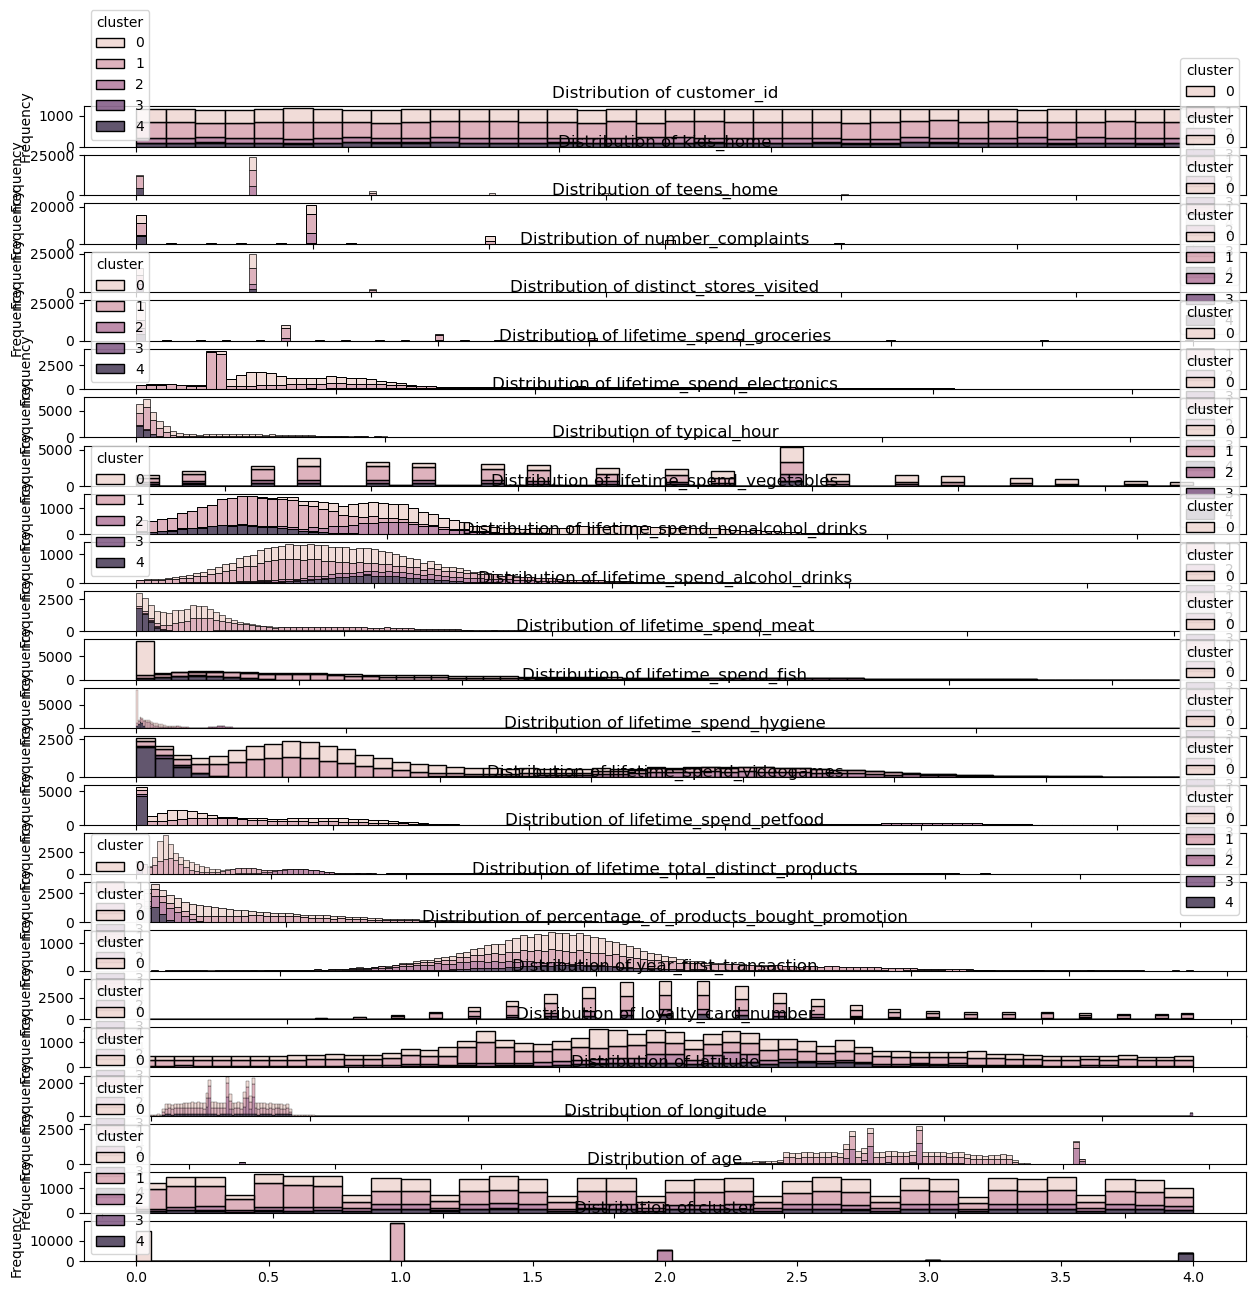

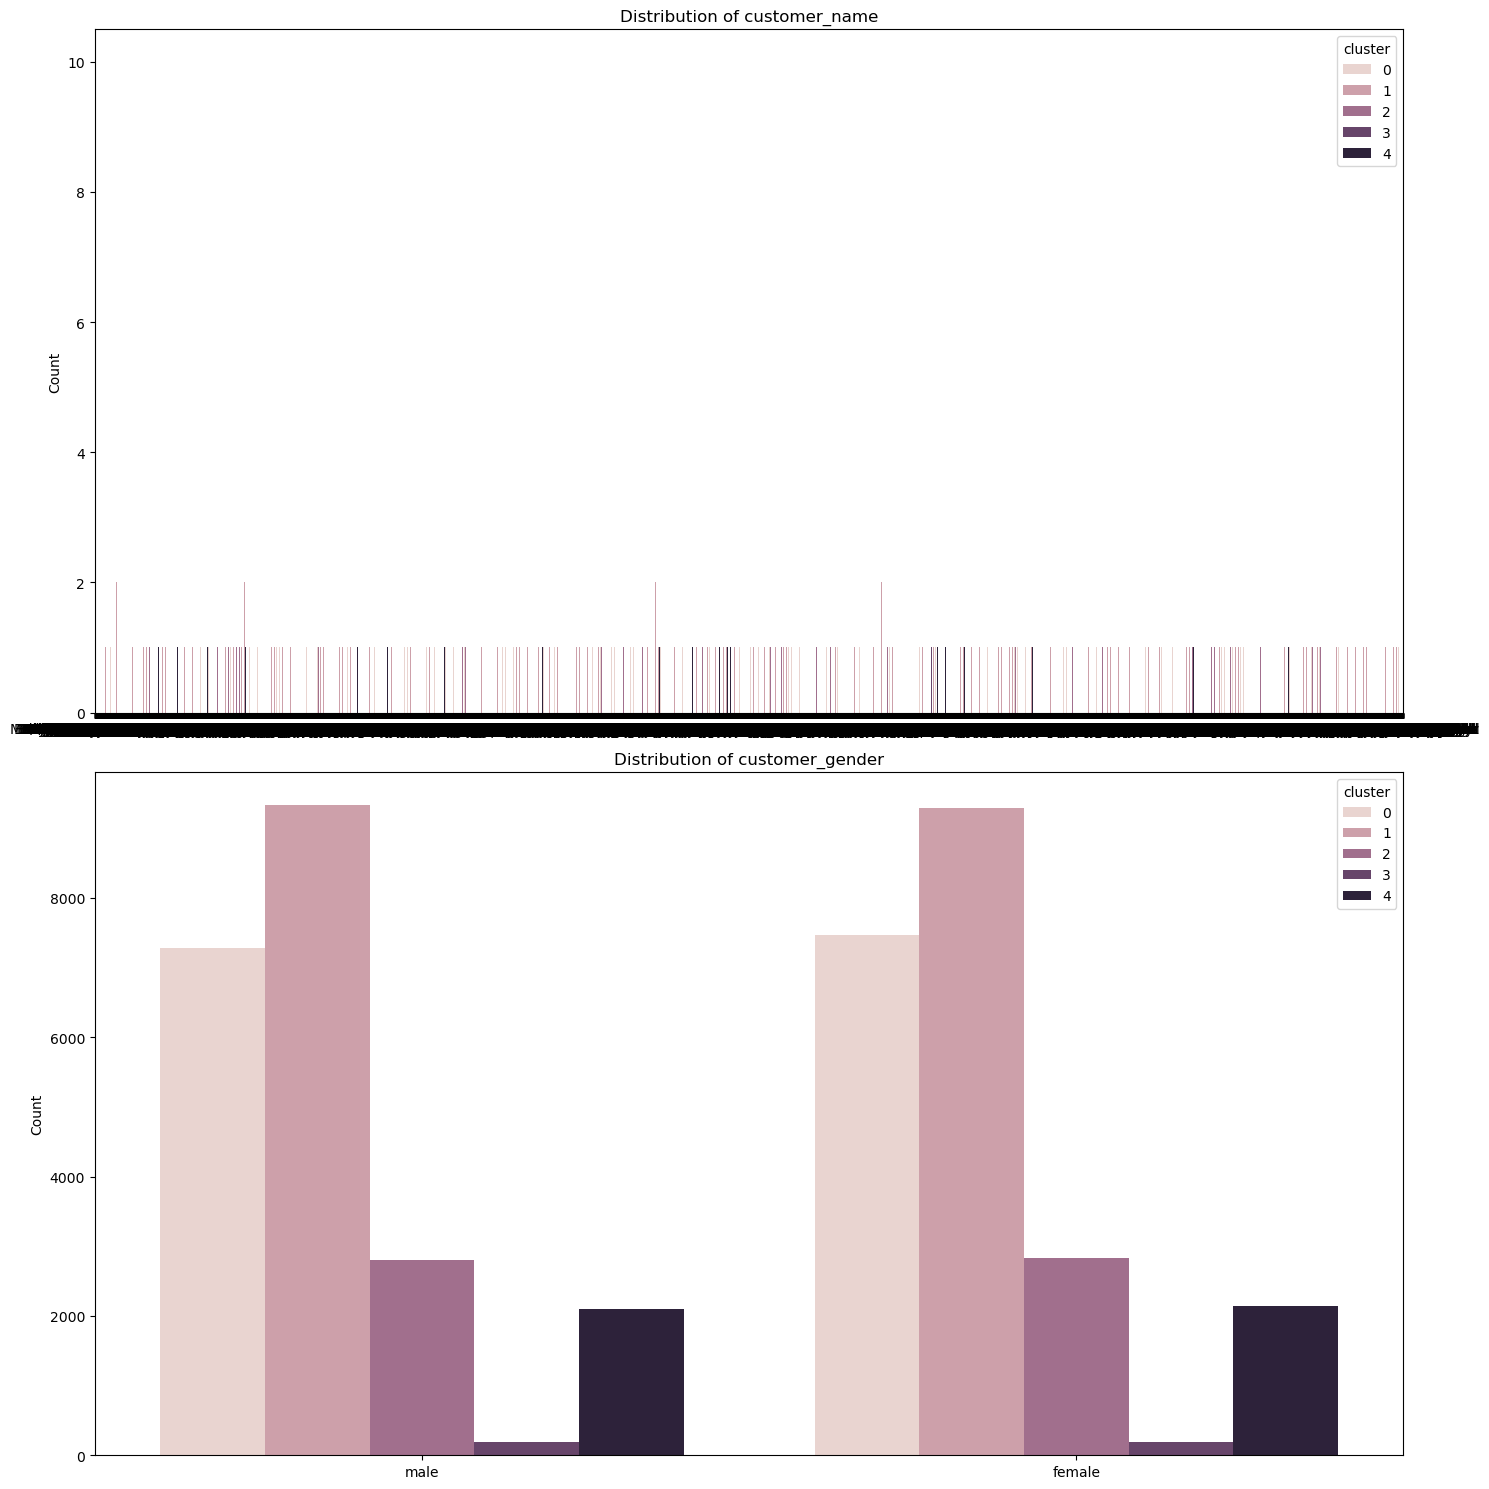

In [49]:
plot_variable_distributions(cust_info, 'cluster')

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_variable_distributions(dataframe, cluster_column, figsize=(15, 15)):
    """
    Plot distributions of all variables for each cluster, with each cluster represented by a different color.

    Parameters:
    - dataframe: DataFrame containing data to plot.
    - cluster_column: Name of the column containing cluster labels.
    - figsize: Tuple specifying the figure size. Default is (15, 15).
    - height: Height of each subplot. Default is 5.
    """
    # Separate numerical and categorical columns
    numerical_cols = dataframe.select_dtypes(include=['number']).columns
    categorical_cols = dataframe.select_dtypes(include=['object']).columns

    # Create subplots for numerical variables
    num_numerical_cols = len(numerical_cols)
    num_categorical_cols = len(categorical_cols)
    num_plots = num_numerical_cols + num_categorical_cols
    fig, axes = plt.subplots(nrows=num_plots, ncols=1, figsize=figsize)
    
    # Iterate over each numerical variable
    for i, numerical_col in enumerate(numerical_cols):
        ax = axes[i]
        sns.histplot(data=dataframe, x=numerical_col, hue=cluster_column, multiple='stack', ax=ax)
        ax.set_title(f'Distribution of {numerical_col}')
        ax.set_xlabel('')
        ax.set_ylabel('Frequency')
        if ax.legend_:
            ax.legend_.remove()

    # Iterate over each categorical variable
    for i, categorical_col in enumerate(categorical_cols, start=num_numerical_cols):
        ax = axes[i]
        sns.countplot(data=dataframe, x=categorical_col, hue=cluster_column, ax=ax)
        ax.set_title(f'Distribution of {categorical_col}')
        ax.set_xlabel('')
        ax.set_ylabel('Count')
        if ax.legend_:
            ax.legend_.remove()

    # Add a single legend for all plots
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

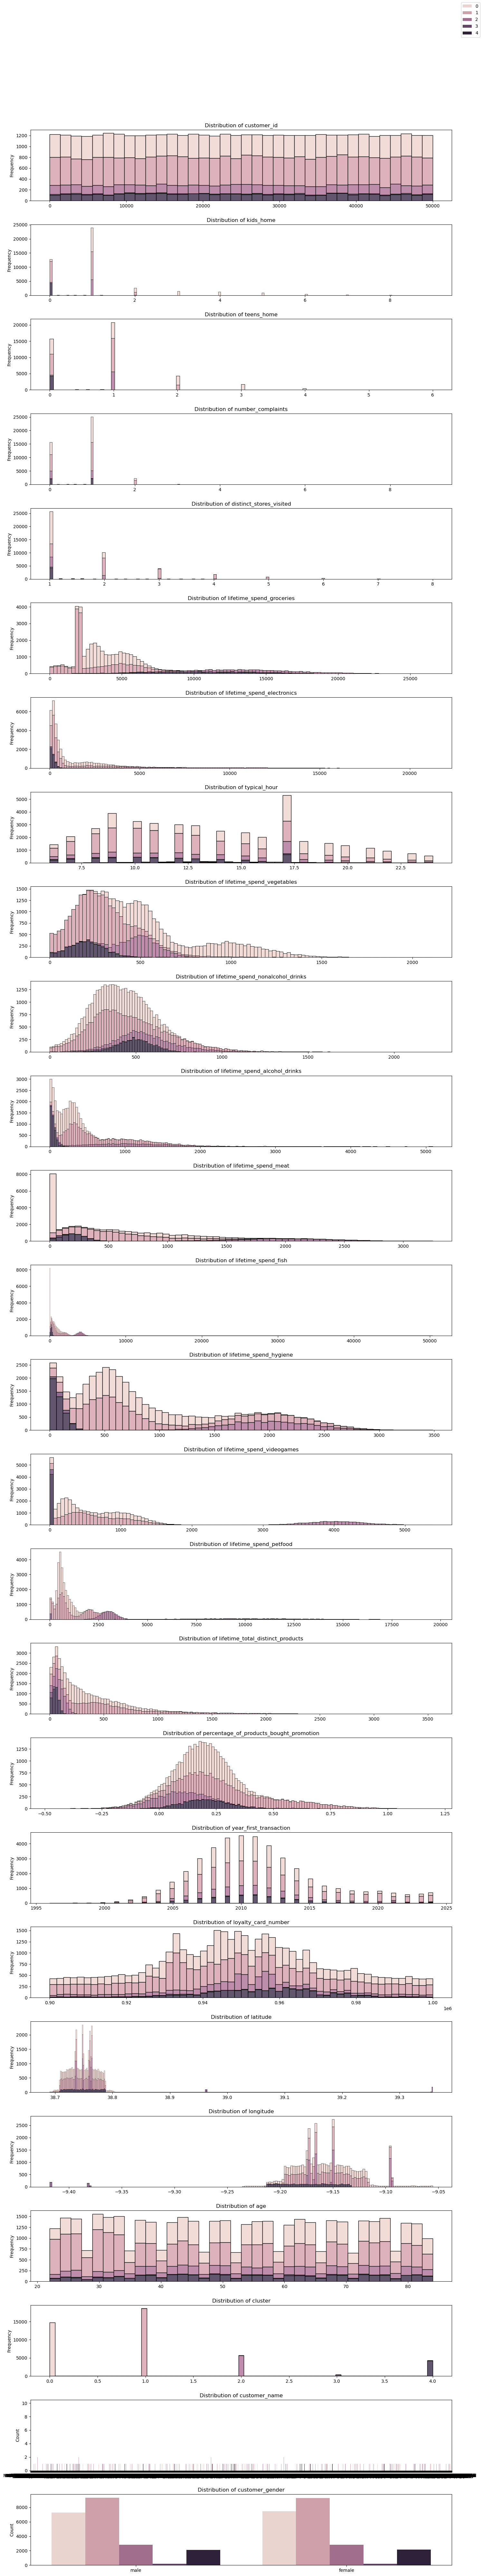

In [57]:
# Example usage
plot_variable_distributions(cust_info, 'cluster', figsize=(15, 80))